In [1]:
import numpy as np
from model import *
from dataloader import *
import matplotlib.pyplot as plt

In [15]:
config = {}
config['epochs'] = 100
config['temperature'] = 1
config['num_neurons'] = 100
config['num_layers'] = 1
config['input_dim'] = None
config['learning_rate'] = 0.001
config['saved_path'] = 'Saved_weights.pth'
config['validation_loss_path'] = 'val_loss.out' #leave empty 
config['training_loss_path'] = 'training_loss.out' #leave empty 


In [3]:
# Check if your system supports CUDA
use_cuda = torch.cuda.is_available()

# Setup GPU optimization if CUDA is supported
if use_cuda:
    computing_device = torch.device("cuda")
    extras = {"num_workers": 1, "pin_memory": True}
    print("CUDA is supported")
else: # Otherwise, train on the CPU
    computing_device = torch.device("cpu")
    extras = False
    print("CUDA NOT supported")

CUDA is supported


In [4]:
train_file = open('train.txt', 'r')
train_file = train_file.read()
train_songs = []

val_file = open('val.txt', 'r')
val_file = val_file.read()
val_songs = []

test_file = open('test.txt', 'r')
test_file = test_file.read()
test_songs = []

#split the songs into their own strings, while including start and end tags
for song in train_file.split('<start>')[1:]:
    #remove \n after <end> tag
    train_songs.append('<start>' + song[:-1])
    
for song in val_file.split('<start>')[1:]:
    #remove \n after <end> tag
    val_songs.append('<start>' + song[:-1])

for song in test_file.split('<start>')[1:]:
    #remove \n after <end> tag
    test_songs.append('<start>' + song[:-1])
    
    
unique_characters = list(set(train_file))
config['input_dim'] = len(unique_characters)

#create one hot encodings for each unique character in the alphabet of the training data
one_hot_dict_encode = {}
one_hot_dict_decode = {}
index = 0
for unique_character in unique_characters:
    current_encoding = np.zeros(len(unique_characters))
    current_encoding[index] = 1
    
    one_hot_dict_encode[unique_character] = current_encoding
    one_hot_dict_decode[tuple(current_encoding)] = unique_character
    
    index += 1


print((unique_characters))

['o', '"', '{', '#', 'e', ':', 'Z', '\\', 'S', 'Q', 'W', 'Y', 'x', '4', ')', 'a', '\n', 'F', 'U', 'E', '<', 't', 'u', '|', 'g', 'M', 'T', '9', 'q', '?', ']', '.', 'w', '}', 'b', ',', 'O', 'B', 'I', '*', 'p', 'C', '!', '2', '6', '/', 'N', 'K', '^', 'H', 'y', ' ', 'c', '@', '0', 'r', 'j', '3', 's', '=', '1', '+', '>', 'k', 'i', 'v', '-', 'A', '&', 'G', 'd', 'P', 'l', 'L', 'f', '\t', 'h', 'X', 'D', '_', '5', 'z', '(', 'J', 'm', '~', "'", '8', 'V', '[', '7', 'n', 'R']


In [5]:
model = Lstm(config['input_dim'], config['num_neurons'], config['num_layers']).to(computing_device)
if not os.path.exists(config['saved_path']):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, config['saved_path'])
    
    np.savetxt(config['training_loss_path'], np.array([0,0]))
    np.savetxt(config['validation_loss_path'], np.array([0,0]))
    
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])

In [16]:
training_losses = np.genfromtxt(config['training_loss_path'])
validation_losses = np.genfromtxt(config['validation_loss_path'])

#restore the model's weights 
checkpoint = torch.load(config['saved_path'])
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

for epoch in range(config['epochs']):
    epoch_loss = 0

    print('EPPPPOCCCHHHHH ' + str(epoch + 1))
    #TODO : randomize the songs here
    
    #train
    model.train()
    for song in train_songs:

        #set states to 0 at the beginning of each song
        hidden_state = torch.zeros((config['num_layers'], 1, config['num_neurons'])).to(computing_device)
        hidden_state = hidden_state.float()
        cell_state = torch.zeros((config['num_layers'], 1, config['num_neurons'])).to(computing_device)
        cell_state = cell_state.float()
        hidden = (hidden_state, cell_state)

        
        #encode the characters to their respective one hot encoding
        encoded_inputs = [one_hot_dict_encode[character] for character in song]
        
        
        #train
        num_minibatches = math.ceil(len(encoded_inputs)/100)
        for i in range(num_minibatches):
            model.zero_grad()

            chunk, targets = MyDataset(encoded_inputs)[i]
            
            if len(chunk) == 0:
                break
            
            chunk = chunk.to(computing_device)
            targets = targets.to(computing_device)
            
            output, hidden = model(chunk, hidden)
            
            loss = criterion(output, targets)
            epoch_loss += loss
            
            loss.backward(retain_graph=True)
            optimizer.step()
      
    #calculate training loss
    average_epoch_loss = epoch_loss/num_minibatches/len(train_songs)
    print('epoch ' + str(epoch + 1) + ' with error '+ str(average_epoch_loss))


        

        
    #validation
    model.eval()
    with torch.no_grad():
        for song in val_songs:
            
            #set states to 0 at the beginning of each song
            hidden_state = torch.zeros((config['num_layers'], 1, config['input_dim'])).to(computing_device)
            cell_state = torch.zeros((config['num_layers'], 1, config['input_dim'])).to(computing_device)
            hidden = (hidden_state, cell_state)
            
    #save model and loss
    torch.save({
        'model_state_dict': net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, config['saved_path'])
    
    np.savetxt(config['training_loss_path'], np.append(training_losses, average_epoch_loss))
#     np.savetxt(config['validation_loss_path'], np.array(cur_validation_losses))
        

OSError: training_loss.out not found.

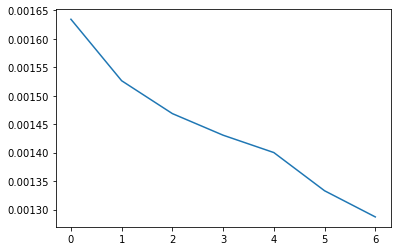

In [11]:
x_axis = []
for i in range(len(training_loss)):
    x_axis.append(i)

plt.figure()
plt.plot(x_axis, training_loss)

In [14]:
# torch.save({
#         'model_state_dict': model.state_dict(),
#         'optimizer_state_dict': optimizer.state_dict(),
#     }, config['saved_path'])